In [1]:
import numpy as np
import pandas as pd
 
from bmfm_targets.datasets.SNPdb.tabix_converter import extract_chr_seq_and_len

np.set_printoptions(precision=3,suppress=True)

/dccstor/bmfm-targets/users/sanjoy/targets_env/anaconda/envs/bmfm_targets/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/dccstor/bmfm-targets/users/sanjoy/targets_env/anaconda/envs/bmfm_targets/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/dccstor/bmfm-targets/users/sanjoy/targets_env/anaconda/envs/bmfm_targets/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/dccstor/bmfm-targets/users/sanjoy/targets_env/anaconda/envs/bmfm_targets/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_

In [2]:
SNPDB_RESOURCES_PATH = "/dccstor/bmfm-targets/data/omics/genome/snpdb/raw/resources/"
fasta_path = SNPDB_RESOURCES_PATH + "GCA_000001405.15_GRCh38_no_alt_analysis_set.fna"
chr_to_seq, chr_to_len = extract_chr_seq_and_len(fasta_path, ">")

In [3]:
def extract_subsequence(sequence, left, right, len_total=None):
    if len_total:
        center = (left + right) // 2
        left = center - len_total // 2
        right = left + len_total
    return sequence[left:right]

def count_variation_percent(sequence):
    return sum([x not in 'ACGTN' for x in sequence]) / len(sequence)

In [4]:
## similar to the reference genome fasta, here I save the biallele-encoded genome to accelerate calculation
path_encoded_seq = '/dccstor/bmfm-targets1/data/omics/genome/snpdb/biallele_encoded_sequence/'
path_encoded_seq_rc = '/dccstor/bmfm-targets1/data/omics/genome/snpdb/biallele_encoded_sequence_rc/'
# 1. X,Y, and other chr IDs are excluded
# 2. the length is around 200
# 3. the reverse seems to be the same sequence e.g.:
# 4. percentage of variantions are calculated

### Process the location file and retrieve both the ref and snpified sequences...

In [5]:
## Load the location of promoter sequences extraced from EPDNew...
epdnew_dataset= "/dccstor/bmfm-targets1/data/omics/genome/finetune_datasets/promoter_prediction/epdnew_chr38_loc.tsv"

df0 = pd.read_csv(epdnew_dataset, header=0, sep="\t")
print(df0.head(), df0.shape)

  #chrom  chromStart  chromEnd       name  score strand  thickStart  thickEnd
0   chr1      959245    959305    NOC2L_1    900      -      959245    959256
1   chr1      960583    960643   KLHL17_1    900      +      960632    960643
2   chr1      966432    966492  PLEKHN1_1    900      +      966481    966492
3   chr1      976670    976730    PERM1_1    900      -      976670    976681
4   chr1     1000086   1000146     HES4_1    900      -     1000086   1000097 (29598, 8)


In [6]:
df0['#chrom'].value_counts()

#chrom
chr1     2923
chr19    2012
chr2     1939
chr11    1805
chr17    1791
chr3     1677
chr12    1621
chr6     1514
chr7     1378
chr5     1372
chr16    1255
chr4     1180
chr9     1148
chr10    1130
chrX     1111
chr8     1029
chr14     947
chr15     933
chr20     834
chr22     746
chr13     500
chr18     443
chr21     308
chrY        2
Name: count, dtype: int64

In [7]:
chrs = df0['#chrom'].unique()
print(chrs)

['chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9' 'chrX'
 'chrY' 'chr10' 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17'
 'chr18' 'chr19' 'chr20' 'chr21' 'chr22']


In [8]:
# if name is unique
print(sum(df0.duplicated(subset=['#chrom', 'chromStart', 'chromEnd'], keep=False))) # 174
df0=df0[~df0.duplicated(subset=['#chrom', 'chromStart', 'chromEnd'], keep='first')] # Remove them
df0['ref_seq'] = None
df0['mut_seq'] = None
print(df0.head(), df0.shape)


174
  #chrom  chromStart  chromEnd       name  score strand  thickStart  thickEnd  \
0   chr1      959245    959305    NOC2L_1    900      -      959245    959256   
1   chr1      960583    960643   KLHL17_1    900      +      960632    960643   
2   chr1      966432    966492  PLEKHN1_1    900      +      966481    966492   
3   chr1      976670    976730    PERM1_1    900      -      976670    976681   
4   chr1     1000086   1000146     HES4_1    900      -     1000086   1000097   

  ref_seq mut_seq  
0    None    None  
1    None    None  
2    None    None  
3    None    None  
4    None    None   (29511, 10)


In [9]:
df0['strand'].value_counts()

strand
+    15191
-    14320
Name: count, dtype: int64

### extract subsequences with/without flank

In [10]:
def reverse_complement(dna_seq):
    # Define the complement mapping
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    
    # Convert to uppercase to handle lowercase input
    dna_seq = dna_seq.upper()
    
    # Find the complement for each base
    comp_seq = [complement[base] if base in complement else 'N' for base in reversed(dna_seq)]

    
    # Reverse the complemented sequence
    rev_comp_seq = ''.join(comp_seq)
    
    return rev_comp_seq

# Example usage
dna = "ATCGCGB"
print("Original:", dna)
print("Reverse complement:", reverse_complement(dna))


Original: ATCGCGB
Reverse complement: NCGCGAT


In [11]:
name_all = []
for i in range(1,23):
    subsequence1_all = []
    #subsequence2_all = []
    subsequence_ref_all = []
    
    target_chr = 'chr' + str(i)
    this_chr_loc = (df0['#chrom']== target_chr)
    the_df = df0[this_chr_loc]
    print('%s has %d samples' % (target_chr, len(the_df)))
    encoded_seq = []
    with open(path_encoded_seq + target_chr + '.txt') as f:
        for line in f:
            encoded_seq.append(line.strip())
    encoded_seq = ''.join(encoded_seq)
    ## reverse complement; start from position N, N-1, ..., 2, 1
    encoded_seq_rc = []
    with open(path_encoded_seq_rc + target_chr + '.txt') as f:
        for line in f:
            encoded_seq_rc.append(line.strip())
    encoded_seq_rc = ''.join(encoded_seq_rc)
    ## there are cases of >200 bp e.g. chr5, start = 141094525, stop = 141094726
    count = 0
    for j in range(len(the_df)):
        left =  int(the_df['chromStart'].iloc[j]) 
        right =  int(the_df['chromEnd'].iloc[j]) 
        if right - left != 60:
            print('NOT 60bp!', target_chr, j, left, right)
        if the_df['strand'].iloc[j] == '+':
            seq1 = extract_subsequence(encoded_seq, left - 200, right + 40)
            seq_ref = extract_subsequence(chr_to_seq[target_chr], left - 200, right + 40)
            #seq2 = extract_subsequence(encoded_seq, left, right, len_total=10000)
        elif the_df['strand'].iloc[j] == '-':
            seq1 = extract_subsequence(encoded_seq_rc, -(right+200), -(left-40))
            seq_ref = reverse_complement(extract_subsequence(chr_to_seq[target_chr], left - 40, right + 200))
            #seq2 = extract_subsequence(encoded_seq_rc, -right, -left, len_total=10000)
        else:
            continue
        #seq0 = the_df["230nt sequence (15nt 5' adaptor - 200nt element - 15nt 3' adaptor)"].iloc[j][15:-15]
        
        # ## check if the original seqs are same as baseline...
        # if (the_df['str.hg38'].iloc[j]=='+') and (seq0!=seq_ref):
        #     count += 1
        #     print('This MPRA seq has inbuilt mutation!', target_chr, j, the_df['str.hg38'].iloc[j])
        #     print(seq0)
        #     print(seq_ref)

        ## check if sequences match
        if sum([x!=y for x,y in zip(seq_ref,seq1)]) / len(seq_ref) > 0.7:
            print('>70% mismatched positions!', target_chr, j, the_df['strand'].iloc[j])
            print(seq_ref)
            print(seq1)
            
        subsequence1_all.append(seq1)
        #subsequence2_all.append(seq2)
        name_all.append(the_df['name'].iloc[j])
        subsequence_ref_all.append(seq_ref)
    # print(f"Total Inbuilt mutations in chr {target_chr} is {count}.")
    print(sum(this_chr_loc), len(subsequence1_all), len(subsequence_ref_all))
    df0.loc[this_chr_loc, 'ref_seq'] = subsequence_ref_all
    df0.loc[this_chr_loc, 'mut_seq'] = subsequence1_all
    


chr1 has 2907 samples
2907 2907 2907
chr2 has 1936 samples
1936 1936 1936
chr3 has 1675 samples
1675 1675 1675
chr4 has 1178 samples
1178 1178 1178
chr5 has 1365 samples
1365 1365 1365
chr6 has 1511 samples
1511 1511 1511
chr7 has 1376 samples
1376 1376 1376
chr8 has 1027 samples
1027 1027 1027
chr9 has 1147 samples
1147 1147 1147
chr10 has 1121 samples
1121 1121 1121
chr11 has 1798 samples
1798 1798 1798
chr12 has 1617 samples
1617 1617 1617
chr13 has 497 samples
497 497 497
chr14 has 947 samples
947 947 947
chr15 has 931 samples
931 931 931
chr16 has 1251 samples
1251 1251 1251
chr17 has 1783 samples
1783 1783 1783
chr18 has 443 samples
443 443 443
chr19 has 2005 samples
2005 2005 2005
chr20 has 832 samples
832 832 832
chr21 has 307 samples
307 307 307
chr22 has 746 samples
746 746 746


In [12]:
print(df0.head(), df0.shape)

  #chrom  chromStart  chromEnd       name  score strand  thickStart  thickEnd  \
0   chr1      959245    959305    NOC2L_1    900      -      959245    959256   
1   chr1      960583    960643   KLHL17_1    900      +      960632    960643   
2   chr1      966432    966492  PLEKHN1_1    900      +      966481    966492   
3   chr1      976670    976730    PERM1_1    900      -      976670    976681   
4   chr1     1000086   1000146     HES4_1    900      -     1000086   1000097   

                                             ref_seq  \
0  GGGGCGGACACCGGCGTCACCGCGTCCTACGGAGCCGGGCGCCGAG...   
1  TCTCGGAGGAGGAGGAGGGCGAGGCCTGGTGGGGGGCTTCCCGGAG...   
2  GCCTGGAAGGTCGCCCCGGGTTCACCAAGCCGGAGCACAAGCAGGT...   
3  GTGGGAGGCGGTTCCCGGGGTTGGCGGGGGGAGTGGGAGGCGGTTC...   
4  CCGGCTGCATCGGGGAGCGCGGGATCACCCGGCCCTGTCCCCAGCG...   

                                             mut_seq  
0  GGGGCGGACACCGGCGTCACCGCGTCCTACGGAGCCGGGCGCCGAG...  
1  TCT则GG高GGAGGAGGAGGGCG高GGCC摄GG摄GGGGGGCTTCCCGGAG...  
2  GCCTGGAA

In [13]:
# Sanity check...
print(df0['ref_seq'].loc[3])
print(extract_subsequence(chr_to_seq['chr1'], 976670, 976730))
rc_seq3 = reverse_complement(extract_subsequence(chr_to_seq['chr1'], 976670, 976730))
print(rc_seq3) # This one is found ....
assert rc_seq3 in df0['ref_seq'].loc[3]

GTGGGAGGCGGTTCCCGGGGTTGGCGGGGGGAGTGGGAGGCGGTTCCCGGGGTTGGCGGGGGGAGTGGGAGGCGGTTCCCGGGGTTGGCGGGGGGAGTGGGAGGCGGTTCCCGGGGTTGGCGGGGGGAGTGGGAGGCGGTTCCCGGGGTTGGCGGGGGGAGTGGGAGGCGGTTCCCGGGGTTGGCGGGGGGAGTGGGAGGCGGTTCCCGGGGTTGGTGGGGGTGGGGGCAGGCGGTTCCCGGGGCGGGCGTGTGCGGGGCCATCTCTGAGTGCAGCCGTGGGGCTGAAGGTGAGCTTCTG
GCCCCGCACACGCCCGCCCCGGGAACCGCCTGCCCCCACCCCCACCAACCCCGGGAACCG
CGGTTCCCGGGGTTGGTGGGGGTGGGGGCAGGCGGTTCCCGGGGCGGGCGTGTGCGGGGC


In [14]:
# See if you stil have duplicates...
print(f"Total unique ref seqs:, {df0['ref_seq'].nunique()} out of 29511.")
print(f"Total unique mut seqs:, {df0['mut_seq'].nunique()} out of 29511.")

Total unique ref seqs:, 28376 out of 29511.
Total unique mut seqs:, 28390 out of 29511.


In [15]:
duplicates = df0[df0.duplicated(subset=['ref_seq'], keep=False)]
df0=df0[~df0.duplicated(subset=['ref_seq'], keep='first')] # Remove them
df0 = df0.dropna(subset=['ref_seq'])
print(df0.shape)


(28376, 10)


### Retrieve the csv file of the dataset to get the label information for positive samples...

In [16]:
base_data_dir = "/dccstor/bmfm-targets1/data/omics/genome/finetune_datasets/promoter_prediction/DNA_BERT2/"
#(cat ${base_data_dir}train.csv && tail -n +2 ${base_data_dir}test.csv &&  tail -n +2 ${base_data_dir}dev.csv) > ${base_data_dir}combined.csv
df_to_be_snpified = pd.read_csv(base_data_dir+"/combined.csv", sep=",")
split_vector = ['train']*47356 + ['test']*5920 + ['dev']* 5920
df_to_be_snpified['split'] = split_vector
print(df_to_be_snpified.head(), df_to_be_snpified.shape)


                                            sequence  label  split
0  TATAATAATAACGAAGATGAGACGACAGTCGACAAGAAAAGCACCA...      0  train
1  AAAGCCCGAGCGGCGGCCACGCCTCGGTGGCGATTTTATTAGCGCT...      1  train
2  AGTCCGCGATATTCTGAGGGGACTTTCGACACAAAAAAGTTGACAC...      0  train
3  ACCCCCCGGCCCCGCCCCACAGACCCCTCCAGTGGTCCCCCGGCCA...      1  train
4  AGGTCTTTGGTCCCCCAACCCTGTGCTCTTTCCACTTAAATCCCGA...      1  train (59196, 3)


In [17]:
print(df_to_be_snpified['label'].value_counts())
print(df_to_be_snpified['split'].value_counts())

label
0    29598
1    29598
Name: count, dtype: int64
split
train    47356
test      5920
dev       5920
Name: count, dtype: int64


In [18]:
print(f"Total unique seqs:, {df_to_be_snpified['sequence'].nunique()} out of 59196.")
df_to_be_snpified_pos = df_to_be_snpified[df_to_be_snpified['label']==1]
print(f"Total unique seqs in pos class:, {df_to_be_snpified_pos['sequence'].nunique()} out of 29598.")
df_to_be_snpified_neg = df_to_be_snpified[df_to_be_snpified['label']==0]
print(f"Total unique seqs in neg class:, {df_to_be_snpified_neg['sequence'].nunique()} out of 29598.")
# Remove the common samples 
common_seqs = set(df_to_be_snpified_pos['sequence']).intersection(df_to_be_snpified_neg['sequence'])
print("Common sequences in pos and neg class:", len(common_seqs))
df_filtered = df_to_be_snpified[~df_to_be_snpified['sequence'].isin(common_seqs)]
print(df_filtered.shape)

# Remove the duplicates...
df_to_be_snpified=df_filtered[~df_filtered.duplicated(subset=['sequence'], keep='first')] # Remove them
print(f"Total unique seqs:, {df_to_be_snpified['sequence'].nunique()} out of 59166.")

Total unique seqs:, 59019 out of 59196.
Total unique seqs in pos class:, 29478 out of 29598.
Total unique seqs in neg class:, 29556 out of 29598.
Common sequences in pos and neg class: 15
(59166, 3)
Total unique seqs:, 59004 out of 59166.


### Combine the two df and then # Look for overlap... 


In [19]:
merged_df_pos = df0.merge(df_to_be_snpified, left_on='ref_seq', right_on='sequence', how='left')
print(merged_df_pos.head(), merged_df_pos.shape)

  #chrom  chromStart  chromEnd       name  score strand  thickStart  thickEnd  \
0   chr1      959245    959305    NOC2L_1    900      -      959245    959256   
1   chr1      960583    960643   KLHL17_1    900      +      960632    960643   
2   chr1      966432    966492  PLEKHN1_1    900      +      966481    966492   
3   chr1      976670    976730    PERM1_1    900      -      976670    976681   
4   chr1     1000086   1000146     HES4_1    900      -     1000086   1000097   

                                             ref_seq  \
0  GGGGCGGACACCGGCGTCACCGCGTCCTACGGAGCCGGGCGCCGAG...   
1  TCTCGGAGGAGGAGGAGGGCGAGGCCTGGTGGGGGGCTTCCCGGAG...   
2  GCCTGGAAGGTCGCCCCGGGTTCACCAAGCCGGAGCACAAGCAGGT...   
3  GTGGGAGGCGGTTCCCGGGGTTGGCGGGGGGAGTGGGAGGCGGTTC...   
4  CCGGCTGCATCGGGGAGCGCGGGATCACCCGGCCCTGTCCCCAGCG...   

                                             mut_seq  \
0  GGGGCGGACACCGGCGTCACCGCGTCCTACGGAGCCGGGCGCCGAG...   
1  TCT则GG高GGAGGAGGAGGGCG高GGCC摄GG摄GGGGGGCTTCCCGGAG...   
2  GCCTG

In [20]:
print(merged_df_pos[merged_df_pos['sequence'].isna()])
print(merged_df_pos[merged_df_pos['ref_seq'] != merged_df_pos['sequence']])
# Looks like these 15 leaked one is only missing, which makes sense...

      #chrom  chromStart   chromEnd        name  score strand  thickStart  \
826     chr1    44800327   44800387      PLK3_1    900      +    44800376   
2118    chr1   162561672  162561732      UAP1_1    900      +   162561721   
9461    chr6    31834866   31834926   C6orf48_1    900      +    31834915   
12459   chr8    73293621   73293681      RPL7_1    900      -    73293621   
12783   chr8   127735558  127735618       MYC_3    900      +   127735607   
14983  chr10   104085790  104085850   COL17A1_1    900      -   104085790   
15011  chr10   110008181  110008241      ADD3_2    900      +   110008230   
15687  chr11    33722712   33722772      CD59_4    900      -    33722712   
15946  chr11    61361871   61361931  CYB561A3_1    900      -    61361871   
16063  chr11    63506295   63506355   LGALS12_2    900      +    63506344   
17012  chr11   133532382  133532442     OPCML_2    900      -   133532382   
17439  chr12    29149252   29149312      FAR2_1    900      +    29149301   

In [21]:
# Drop those ones...
merged_df_pos=merged_df_pos.dropna(subset=['sequence'])
print("# of seqs after removing the 15 leaked samples:", merged_df_pos.shape)
assert(merged_df_pos[merged_df_pos['sequence'].isna()].shape[0] == 0)
print(merged_df_pos['label'].value_counts())

print("!!!! These positive samples are in negative set: ")
print(merged_df_pos[merged_df_pos['label']==0])

# of seqs after removing the 15 leaked samples: (28361, 13)
label
1.0    28361
Name: count, dtype: int64
!!!! These positive samples are in negative set: 
Empty DataFrame
Columns: [#chrom, chromStart, chromEnd, name, score, strand, thickStart, thickEnd, ref_seq, mut_seq, sequence, label, split]
Index: []


In [22]:
## calculate percentage of variations

var_percent1 = merged_df_pos['mut_seq'].apply(count_variation_percent)

print("percentage of variation(300): %.2f%%" % (sum(var_percent1)/len(var_percent1)*100))


percentage of variation(300): 1.04%


In [23]:
var_percent1 = [var*300 for var in var_percent1]
print(len(var_percent1), min(var_percent1), max(var_percent1))


28361 0.0 193.99999999999997


### Plot the original distribution...

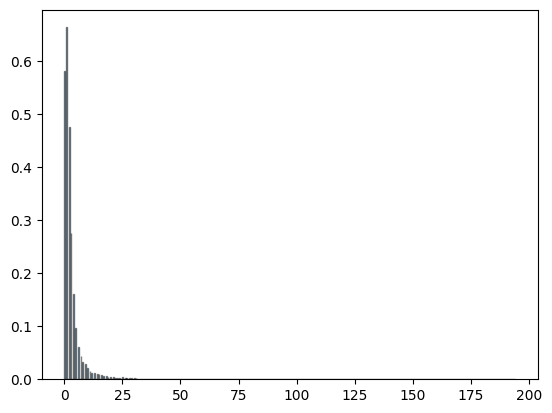

In [24]:
import matplotlib.pyplot as plt

plt.hist(var_percent1, bins=500, alpha=0.5, edgecolor='black', label='Original Data', density=True)
plt.show()

In [25]:
print(var_percent1)

[2.0, 13.0, 1.0, 37.0, 5.0, 5.0, 10.0, 20.0, 7.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 4.0, 3.0, 0.0, 11.0, 6.0, 3.0, 0.0, 3.0, 1.0, 1.0, 1.0, 9.0, 1.0, 0.0, 0.0, 0.0, 2.0, 4.0, 1.0, 2.0, 0.0, 2.0, 3.0, 4.0, 5.0, 2.0, 4.0, 10.0, 14.0, 2.0, 22.0, 2.0, 5.0, 1.0, 2.0, 9.0, 7.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 17.0, 1.0, 2.0, 6.0, 5.0, 1.0, 9.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 4.0, 5.0, 2.0, 11.0, 6.0, 1.0, 3.0, 1.0, 14.0, 36.0, 1.0, 1.0, 11.0, 0.0, 2.0, 0.0, 1.0, 31.0, 4.0, 2.0, 3.0, 1.0, 10.0, 1.0, 0.0, 3.0, 85.0, 1.0, 10.0, 1.0, 2.0, 9.0, 3.0, 3.0, 1.0, 1.0, 6.0, 2.0, 6.0, 2.0, 10.0, 12.0, 3.0, 0.0, 15.0, 10.0, 13.0, 1.0, 2.0, 4.0, 6.0, 2.0, 1.0, 3.0, 1.0, 8.0, 1.0, 1.0, 0.0, 0.0, 1.0, 22.0, 1.0, 3.0, 2.0, 2.0, 2.0, 0.0, 0.0, 5.0, 1.0, 4.0, 15.0, 1.0, 0.0, 7.0, 1.0, 22.0, 1.0, 1.0, 20.0, 1.0, 14.0, 8.0, 1.0, 1.0, 1.0, 6.0, 11.0, 7.0, 2.0, 19.0, 2.0, 2.0, 3.0, 8.0, 1.0, 0.0, 0.0, 0.0, 7.0, 12.0, 1.0, 0.0, 0.0, 2.0, 1.0, 18.0, 3.0, 1.0, 3.0, 0.0

### Now find the non-parameter distribution...

# now create the negative samples...

In [26]:
import json
import random


def replace_a_seq_at_random_pos(s,no_pos,snp_vocab):
    if len(s) < no_pos:
        raise ValueError(f"String must be at least {no_pos} characters long.")
    
    s_list = list(s) 
    try:
        # Pick a random position in the string
        positions = random.sample(range(len(s)), no_pos)

        # Generate random snps
        letters = random.choices(snp_vocab, k=no_pos)

         # Replace the character at pos with the snps
        for pos, letter in zip(positions, letters):
            s_list[pos] = letter

    except:
         print("error:", s, no_pos)
    
    return ''.join(s_list)

   


SNP_lexicon = SNPDB_RESOURCES_PATH + "biallele_lexicon.json"
with open(SNP_lexicon) as file:
    snp_dict = json.load(file)

chinese_chars = [snp_dict[k] for k in snp_dict if "_" in k]
print("chinese chars: ", chinese_chars)
print("# of chinese chars: ", len(chinese_chars))

print(replace_a_seq_at_random_pos("ATCGGGTAAT", 2, chinese_chars))
print(replace_a_seq_at_random_pos("ATCGGGTAAT", 0, chinese_chars))



chinese chars:  ['帝', '高', '阳', '之', '苗', '裔', '兮', '朕', '皇', '考', '曰', '伯', '庸', '摄', '提', '贞', '于', '孟', '陬', '惟', '庚', '寅', '吾', '以', '降', '览', '揆', '余', '初', '度', '肇', '锡', '嘉', '名', '正', '则', '字', '灵', '均', '纷', '既', '有', '此', '内', '美', '又', '重', '修', '能', '扈', '江', '离', '与', '辟', '芷', '纫', '秋', '兰', '为', '佩', '汩', '若', '将', '不', '及', '恐', '年', '岁', '朝', '搴', '阰', '木', '夕', '揽', '洲', '宿', '莽', '日', '月', '忽', '其', '淹', '春', '代', '序', '草', '零', '落', '人', '迟', '暮', '抚', '壮', '而', '弃', '秽', '何', '改', '乘', '骐', '骥', '驰', '骋', '来', '道', '夫', '先', '路', '昔', '三', '后', '纯', '粹', '固', '众', '芳', '所', '在', '杂', '申', '椒']
# of chinese chars:  121
度TCGGGTA美T
ATCGGGTAAT


0.0 193.0
                                             sequence  label  split  no_pos
0   TATAATAATAACGAAGATGAGACGACAGTCGACAAGAAAAGCACCA...      0  train     0.0
2   AGTCCGCGATATTCTGAGGGGACTTTCGACACAAAAAAGTTGACAC...      0  train     8.0
7   AGTGGGAATGGCAAGACGTTCCGAGTAGAAACTCCTTAATGAGTGA...      0  train     1.0
9   TTTGCAGCAAAGAAGCCCTAGACCTTGGGAGGCTTTAGATTCCAAC...      0  train     0.0
13  GTGAACAACCAGCCCGCCATTCGGTGAAATCCAACGCATATTGGCT...      0  train     5.0


/tmp/ipykernel_297871/2689921125.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_be_snpified_neg['no_pos'] = samples
/tmp/ipykernel_297871/2689921125.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_be_snpified_neg["mut_seq"] = df_to_be_snpified_neg.apply(lambda row: replace_a_seq_at_random_pos(row['sequence'], int(row['no_pos']), chinese_chars), axis=1)


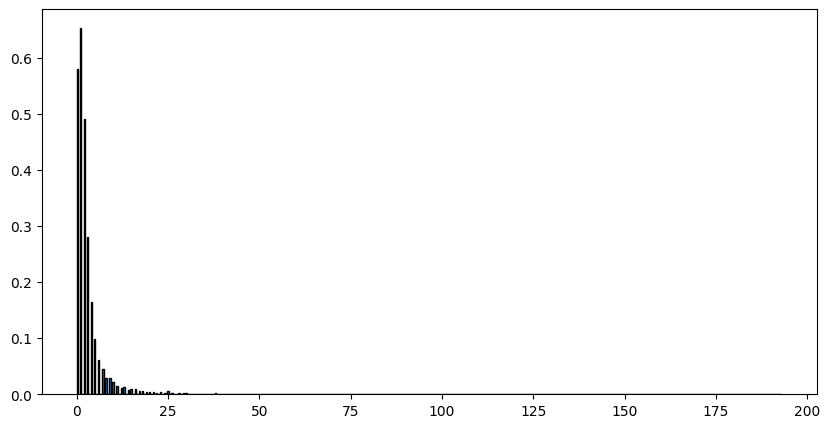

In [27]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

data = np.array(var_percent1).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(data)
# Find the negative samples of the data...
df_to_be_snpified_neg = df_to_be_snpified[df_to_be_snpified['label']==0]
samples = kde.sample(n_samples=df_to_be_snpified_neg.shape[0])
samples = np.round(samples.reshape(-1))
samples[samples<=0] = 0
print(min(samples), max(samples))
df_to_be_snpified_neg['no_pos'] = samples
print(df_to_be_snpified_neg.head())
plt.figure(figsize=(10, 5))
plt.hist(samples, bins=500, edgecolor='black', label='Synthetic Data on neg', density=True)


df_to_be_snpified_neg["mut_seq"] = df_to_be_snpified_neg.apply(lambda row: replace_a_seq_at_random_pos(row['sequence'], int(row['no_pos']), chinese_chars), axis=1)

    

In [28]:
print(len(df_to_be_snpified_neg))
df_to_be_snpified_neg.head(20)

29541


,sequence,label,split,no_pos,mut_seq
0,TATAATAATAACGAAGATGAGACGACAGTCGACAAGAAAAGCACCA...,0,train,0.0,TATAATAATAACGAAGATGAGACGACAGTCGACAAGAAAAGCACCA...
2,AGTCCGCGATATTCTGAGGGGACTTTCGACACAAAAAAGTTGACAC...,0,train,8.0,AGTCC三CGATATTCTG既GGGGACTTTCGACACAAAAAAGTTGACAC...
7,AGTGGGAATGGCAAGACGTTCCGAGTAGAAACTCCTTAATGAGTGA...,0,train,1.0,AGTGGGAATGGCAAGACGTTCCGAGTAGAAACTCCTTAATGAGTGA...
9,TTTGCAGCAAAGAAGCCCTAGACCTTGGGAGGCTTTAGATTCCAAC...,0,train,0.0,TTTGCAGCAAAGAAGCCCTAGACCTTGGGAGGCTTTAGATTCCAAC...
13,GTGAACAACCAGCCCGCCATTCGGTGAAATCCAACGCATATTGGCT...,0,train,5.0,GTGAACAACCAGCCCGCCATTCGGTGAAATCCAACG众ATATTGGCT...
17,GGCAAGCCTTTGATGTGCGGCCCACGAGGTAATTTGTGACTTTATC...,0,train,0.0,GGCAAGCCTTTGATGTGCGGCCCACGAGGTAATTTGTGACTTTATC...
20,ACTTATATTTTGGTGTGATGTCTTGATGTCGTTAATGGTACTCTGC...,0,train,2.0,ACTTATATTTTGGTGTGATGTCTTGATGTC三TTAATGGTACTCTGC...
21,GTGTCCTACTTCAAATGTGTGCAGAAGGAGGTCCTGCCGTCCATGC...,0,train,5.0,GTGTCC秽ACTTCAAATGTGTGCAGAAGGAGGTCCTGCCGTCCATGC...
22,CTGCATGGGGCTCGTGAATCATAACGCCGTAGTCTAGTCGAGTCCG...,0,train,1.0,CTGCATGGGGCTCGTGAATCATAACGCCGTAGTCTAGTCGAGTCCG...
26,ATTTCAGGACCAGCACCGGCAGTGGCGGGACCCACACCTACTCCGC...,0,train,3.0,ATTTCAGGA余CAGCACCGGCAGTGGCGGGACCCACACCTACTCCGC...


In [29]:
print(merged_df_pos.shape, merged_df_pos.head())

(28361, 13)   #chrom  chromStart  chromEnd       name  score strand  thickStart  thickEnd  \
0   chr1      959245    959305    NOC2L_1    900      -      959245    959256   
1   chr1      960583    960643   KLHL17_1    900      +      960632    960643   
2   chr1      966432    966492  PLEKHN1_1    900      +      966481    966492   
3   chr1      976670    976730    PERM1_1    900      -      976670    976681   
4   chr1     1000086   1000146     HES4_1    900      -     1000086   1000097   

                                             ref_seq  \
0  GGGGCGGACACCGGCGTCACCGCGTCCTACGGAGCCGGGCGCCGAG...   
1  TCTCGGAGGAGGAGGAGGGCGAGGCCTGGTGGGGGGCTTCCCGGAG...   
2  GCCTGGAAGGTCGCCCCGGGTTCACCAAGCCGGAGCACAAGCAGGT...   
3  GTGGGAGGCGGTTCCCGGGGTTGGCGGGGGGAGTGGGAGGCGGTTC...   
4  CCGGCTGCATCGGGGAGCGCGGGATCACCCGGCCCTGTCCCCAGCG...   

                                             mut_seq  \
0  GGGGCGGACACCGGCGTCACCGCGTCCTACGGAGCCGGGCGCCGAG...   
1  TCT则GG高GGAGGAGGAGGGCG高GGCC摄GG摄GGGGGGCTTCCCGGAG...

In [30]:
# Finally concat these two df....
snpified_df = pd.concat([merged_df_pos[['sequence', 'mut_seq', 'label', 'split']], df_to_be_snpified_neg[['sequence', 'mut_seq', 'label', 'split']]])
print(snpified_df.shape, snpified_df.head())

(57902, 4)                                             sequence  \
0  GGGGCGGACACCGGCGTCACCGCGTCCTACGGAGCCGGGCGCCGAG...   
1  TCTCGGAGGAGGAGGAGGGCGAGGCCTGGTGGGGGGCTTCCCGGAG...   
2  GCCTGGAAGGTCGCCCCGGGTTCACCAAGCCGGAGCACAAGCAGGT...   
3  GTGGGAGGCGGTTCCCGGGGTTGGCGGGGGGAGTGGGAGGCGGTTC...   
4  CCGGCTGCATCGGGGAGCGCGGGATCACCCGGCCCTGTCCCCAGCG...   

                                             mut_seq  label  split  
0  GGGGCGGACACCGGCGTCACCGCGTCCTACGGAGCCGGGCGCCGAG...    1.0  train  
1  TCT则GG高GGAGGAGGAGGGCG高GGCC摄GG摄GGGGGGCTTCCCGGAG...    1.0    dev  
2  GCCTGGAAGGTCGCCCCGGGTTCACCAAGCCGGAGCACAAGCAGGT...    1.0  train  
3  G摄GGG正GG正GG摄TCC则GGGG摄兰G秋则GGGGGGAG摄GG正AGGCGGTTC...    1.0  train  
4  CCGGCTGCATC高GGGAGCGCGGGATCACCCGGCCCTGTCCCCAGCG...    1.0    dev  


In [31]:
# input_file = "/dccstor/bmfm-targets1/data/omics/genome/MPRA/sup_nature/2023-03-03628-s5/2023-03-03628C-Table S3 - large-scale lib design_K562.csv"
# This is the processed output path...
from pathlib import Path

base_path = Path('/dccstor/bmfm-targets1/data/omics/genome/finetune_datasets/promoter_prediction/DNA_BERT2')
output_dir1 = base_path 
#output_dir1.mkdir(parents=True, exist_ok=False)
output1_path = str(output_dir1 / 'promoters_snpified_300.csv')


snpified_df.to_csv(output1_path, index=False)

In [32]:
# Generate new ref_genome
ref_gen_dir = output_dir1 / "ref_genome"
!mkdir -p "$ref_gen_dir"
snpified_df.loc[snpified_df['split']=='train',["sequence","label"]].to_csv(ref_gen_dir / 'train.csv', index=False)
snpified_df.loc[snpified_df['split']=='test',["sequence","label"]].to_csv(ref_gen_dir / 'test.csv', index=False)
snpified_df.loc[snpified_df['split']=='dev',["sequence","label"]].to_csv(ref_gen_dir / 'dev.csv', index=False)

snp_gen_dir = output_dir1 / "snp_genome"
!mkdir -p "$snp_gen_dir"
snpified_df.loc[snpified_df['split']=='train',["mut_seq","label"]].to_csv(snp_gen_dir / 'train.csv', index=False)
snpified_df.loc[snpified_df['split']=='test',["mut_seq","label"]].to_csv(snp_gen_dir / 'test.csv', index=False)
snpified_df.loc[snpified_df['split']=='dev',["mut_seq","label"]].to_csv(snp_gen_dir / 'dev.csv', index=False)



In [1]:
import pandas as pd

df_combined = pd.read_csv("/dccstor/bmfm-targets1/data/omics/genome/finetune_datasets/promoter_prediction/DNA_BERT2/snpified_v1/snp_genome/combined.csv")



(57902, 2)                                              mut_seq  label
0  GGGGCGGACACCGGCGTCACCGCGTCCTACGGAGCCGGGCGCCGAG...      1
1  GCCTGGAAGGTCGCCCCGGGTTCACCAAGCCGGAGCACAAGCAGGT...      1
2  G摄GGG正GG正GG摄TCC则GGGG摄兰G秋则GGGGGGAG摄GG正AGGCGGTTC...      1
3  ATGGCATGCGGGGCCCC则GCCCGCGCCCC正CTCCGACACCGCTGGG...      1
4  GATATTT高GGTGTT则CC高GGGTGTTGGG摄GGGGG摄GGGGATGCCGT...      1


In [2]:
df_combined_pos = df_combined[df_combined['label'] == 1]
print(df_combined_pos.shape)

(28361, 2)


In [4]:
print(df_combined_pos.shape, df_combined_pos.head(20))

(28361, 2)                                               mut_seq  label
0   GGGGCGGACACCGGCGTCACCGCGTCCTACGGAGCCGGGCGCCGAG...      1
1   GCCTGGAAGGTCGCCCCGGGTTCACCAAGCCGGAGCACAAGCAGGT...      1
2   G摄GGG正GG正GG摄TCC则GGGG摄兰G秋则GGGGGGAG摄GG正AGGCGGTTC...      1
3   ATGGCATGCGGGGCCCC则GCCCGCGCCCC正CTCCGACACCGCTGGG...      1
4   GATATTT高GGTGTT则CC高GGGTGTTGGG摄GGGGG摄GGGGATGCCGT...      1
5   ACGGCCGCGCCGGGCGCTGCGTCCCGGGGCTTTGTTCGCGGCGGCG...      1
6   TGGGAGGGCCGGGCGGAGGGGCAGCAACTGGGGCTCAGGCTCAGGC...      1
7   CACCAGGCAGGCGGCCTCTGAGGTGT则GACGGGCCTCCAGGGGACT...      1
8   CCCCTGCACTGGGGACACCAATGTGGCCGCAGACTTTGCATAGAAA...      1
9   GTGGCCAGAATTTGTGGAGACCTCTCGGGGACTCGCAGATACCACC...      1
10  CTTTTTGCTGAGGGTCGAGCCGCAGGCCAGGCCCTACTGTGCCCTG...      1
11  CCGGACTCGCGAGTGCGCAGGCGCCGCCGGCTCGGGGCGGTGCGCG...      1
12  GGGGAGGGAAGCGCGCGGCTTCGGGGTCTGGGGCTCTCGCGCCCAC...      1
13  AGTTA则GGGGGCTGTGGGGCTGCAGTAGGTGCCGTAGAG则GACTGC...      1
14  CCACATTTCCACCGACTGTCCCCGGAGACGGCCGTGGCAGGCCCCG...      1
15  CGCGCCGCG

In [13]:
unique_chars = (''.join(df_combined_pos['mut_seq']))
non_acgtn_chars = {c for c in unique_chars if c not in 'ACGTN'}
print(len(non_acgtn_chars)/121)


0.2066115702479339
